In [1]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot, CoV_plot, mapped_samples_pair_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    ci_perf_on_dset,
    perfs_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range, convert_array_range

import matplotlib as mpl
import matplotlib.pyplot as plt

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
# remove all edges

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2

font = {"weight": "bold"}
mpl.rc("font", **font)

# grid alpha to 0.2
mpl.rcParams["grid.alpha"] = 0.2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
from features.features import *

src/username/data/NSC/data/dataset_L0_exp_set_0.h5


## Slice sampling plot

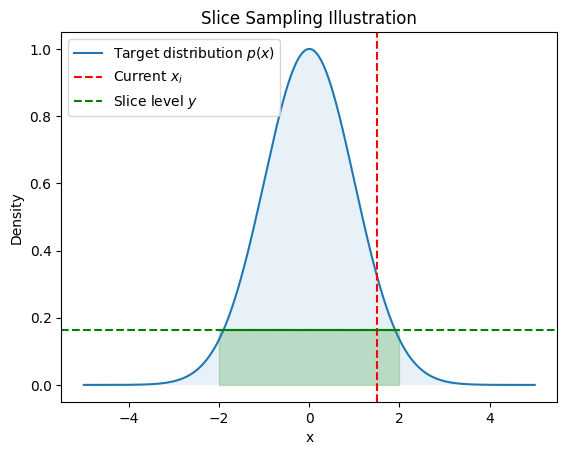

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example target distribution function (replace with your actual function)
def p(x):
    return np.exp(-x**2 / 2)

# Domain and range
x = np.linspace(-5, 5, 1000)
y = p(x)

# Example slice parameters
x_current = 1.5
y_slice = p(x_current) * 0.5
slice_interval = (-2, 2)

# Plot the distribution
plt.plot(x, y, label='Target distribution $p(x)$')
plt.fill_between(x, y, alpha=0.1)

# Plot the vertical slice
plt.axvline(x_current, color='red', linestyle='--', label='Current $x_i$')
plt.axhline(y_slice, color='green', linestyle='--', label='Slice level $y$')

# Plot the horizontal slice
plt.hlines(y_slice, slice_interval[0], slice_interval[1], color='green')
plt.fill_betweenx([y_slice, 0], slice_interval[0], slice_interval[1], color='green', alpha=0.2)

plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Slice Sampling Illustration')
plt.savefig('slice_sampling_diagram.png')
plt.show()


## load data for CoV

In [2]:
fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")
valid_data_dir = f"{fig_dir}/compare/dataset_varying_params.pt"
data = torch.load(valid_data_dir)
x_o = data["x_o"]
seqC_o = data["seqC_o"]
params = data["params"]
probR = data["probR"]
chR = data["chR"]
prior_labels = data["prior_labels"]
normed_limits = data["normed_limits"]
designed_limits = data["designed_limits"]
step = 7
nT = 28
num_params = 4
C_idx = 0
D, M, S = seqC_o.shape[0], seqC_o.shape[1], seqC_o.shape[2]
DMS = D * M * S

# map 3, 5, 7, 9, 11, 13, 15
chosen_dur_list = np.array([3, 9, 15])
chosen_dur_idx = ((chosen_dur_list - 3) / 2).astype(int)

x_o_chosen_dur = x_o[chosen_dur_idx].reshape(-1, 15)
x_o_all = x_o.reshape(-1, 15)
print(f"==>> x_o_chosen_dur.shape: {x_o_chosen_dur.shape}")
print(f"==>> x_o_all.shape: {x_o_all.shape}")

==>> x_o_chosen_dur.shape: torch.Size([6300, 15])
==>> x_o_all.shape: torch.Size([14700, 15])


In [3]:
pipeline_version = "nle-p2"
train_id = "L0-nle-p2-cnn"
exp_id = "L0-nle-p2-cnn-datav2-small-batch-newLoss"
log_exp_id = "nle-p2-cnn-datav2-newLoss"
use_chosen_dur = 0
T_idx = 0
iid_batch_size_theta = 100

# pipeline_version = "nle-p3"
# train_id = "L0-nle-p3-cnn"
# exp_id = "L0-nle-p3-cnn-newLoss-tmp-2"
# log_exp_id = "nle-p3-cnn-newLoss"
# use_chosen_dur = 0
# T_idx = 0
# iid_batch_size_theta = 100

## load training events

In [54]:
# %% ========== load the latest event file
log_dir = Path(NSC_DIR) / "codes/src/train_nle/logs" / train_id / exp_id
(
    wall_time,
    step_nums,
    learning_rates,
    loss_train,
    loss_valid,
) = get_train_valid_lr(log_dir, use_loss=True)

# %% ========== load the config.yaml file
config_file = log_dir / "config.yaml"
config = adapt_path(config_file)

with open(config, "r") as f:
    config = yaml.safe_load(f)

prior_min = config["prior"]["prior_min"]
prior_max = config["prior"]["prior_max"]
# prior_labels = config["prior"]["prior_labels"]
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]
fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['learning_rates'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


## training curve

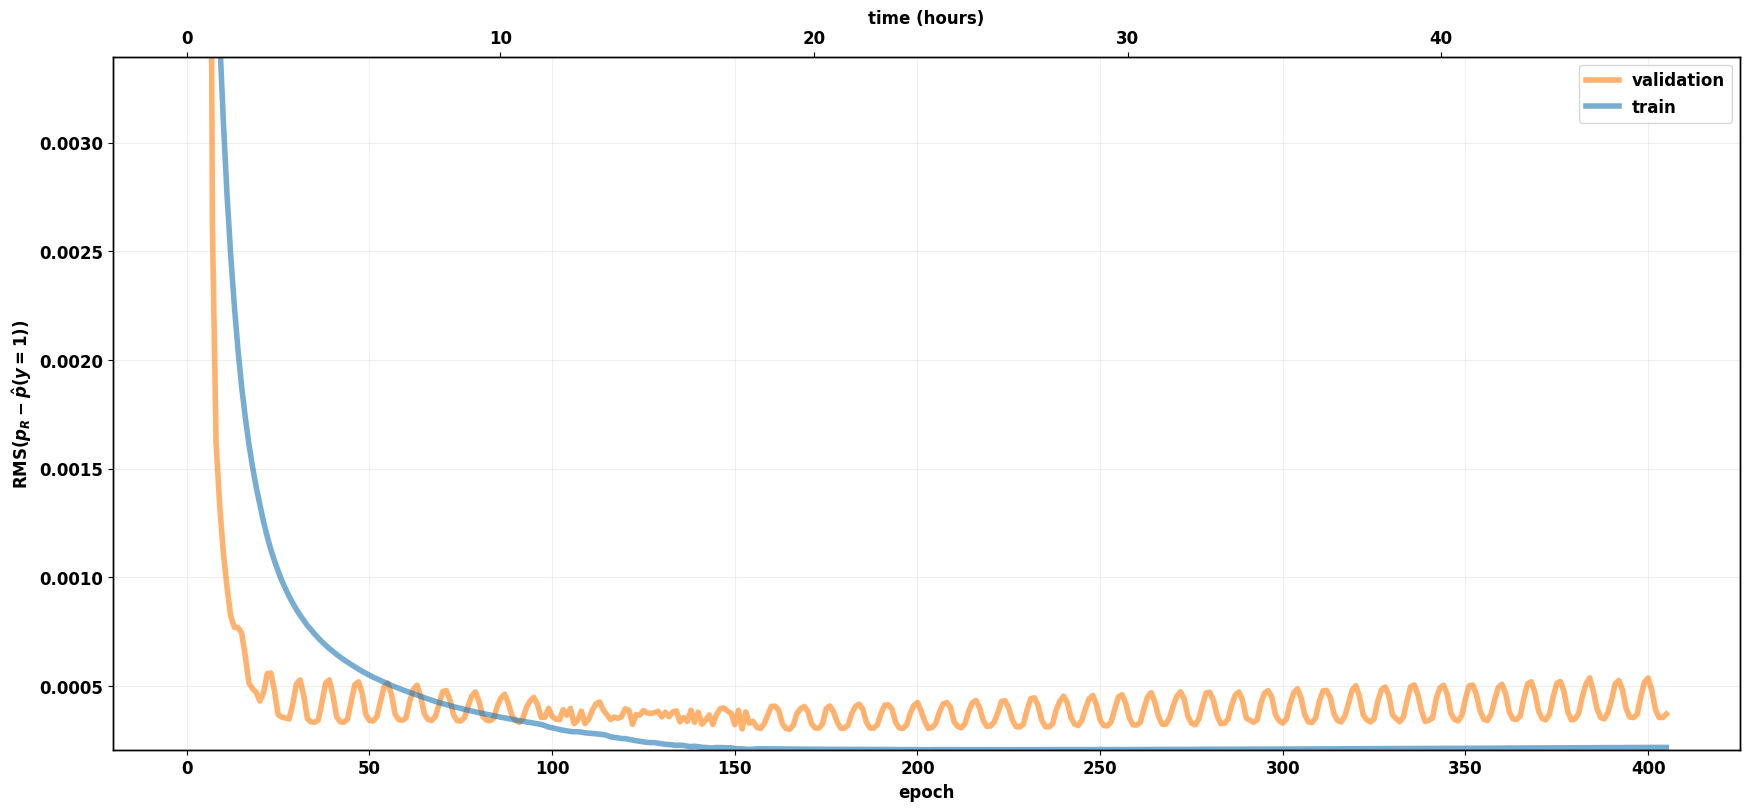

In [55]:
all_loss = np.concatenate([loss_train, loss_valid])
upper = np.percentile(all_loss, 98)
lower = np.min(all_loss)

# %% ========== plot training curves
fig, ax = plt.subplots(figsize=(21, 9))
ax.plot(step_nums, loss_valid, label="validation", alpha=0.6, ms=0.2, color=colors[1], lw=4)
ax.plot(step_nums, loss_train, label="train", alpha=0.6, ms=0.2, color=colors[0], lw=4)
ax.set_ylim(lower, upper)
ax.set_xlabel("epoch")
ax.set_ylabel("RMS$(p_R-\hat{p}(y=1))$")
ax.grid(alpha=0.2)
ax.legend()

ax1 = ax.twiny()
ax1.plot(
    (np.array(wall_time) - wall_time[0]) / 60 / 60,
    max(loss_valid) * np.ones_like(loss_valid),
    "-",
    alpha=0,
)
ax1.set_xlabel("time (hours)")

save_fig = fig_dir / 'nle' / f'{log_exp_id}-training-curve.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

In [56]:
np.sqrt(0.0003)

0.017320508075688773

## check the trained model

In [157]:
log_dir = Path(NSC_DIR) / "codes/src/train_nle/logs" / train_id / exp_id

config_nle, model_path_nle = load_stored_config(exp_dir=log_dir)

if "p2" in pipeline_version:
    from train_nle.train_p2 import Solver
if "p3" in pipeline_version:
    from train_nle.train_p3 import Solver

solver_nle = Solver(config_nle, store_config=False)
solver_nle.init_inference(
    iid_batch_size_x=config_nle.posterior.MCMC_iid_batch_size_x,  #!
    # iid_batch_size_theta=config_nle.posterior.MCMC_iid_batch_size_theta,  # + info: 10000 MCMC init, other time 1
    iid_batch_size_theta=iid_batch_size_theta,  # + info: 10000 MCMC init, other time 1
    sum_writer=False,
)

# get the trained network
_, _, density_estimator, train_dataset, valid_dataset = solver_nle.inference.prepare_dataset_network(
    config_nle,
    continue_from_checkpoint=model_path_nle,
    device="cuda" if torch.cuda.is_available() and config_nle.gpu else "cpu",
    print_info=True,
    inference_mode=True,
    low_batch=5,
)

==>> config_path: /home/wehe/data/NSC/codes/src/train_nle/logs/L0-nle-p3-cnn/L0-nle-p3-cnn-newLoss-tmp-2/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
--- CUDA info ---

prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]
prepare train, val dataset and dataloader
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets
start loading data into MEM ... 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ==================================================
[dataset info]
total # samples: 132300000
chosen sets ['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22'

In [175]:
# check estimator's output using prepared validation dataset
D_idx = 5
M_idx = 0
S_idx = 10
T_idx = 12

x_o_test = torch.cat((x_o[D_idx, M_idx, S_idx, :][1:], torch.tensor([1])))
probR_test = probR[D_idx, M_idx, S_idx, T_idx, :]
params_test = params[T_idx, :]
x_o_test = x_o_test.reshape(1, -1).to(dtype=torch.float32)
params_test = convert_samples_range(params_test, designed_limits, normed_limits)
params_test = params_test.reshape(1, -1).to(dtype=torch.float32)
print(f"==>> x_o_test: {x_o_test}")
print(f"==>> params_test: {params_test}")

log_prob = density_estimator.log_prob(
    x = x_o_test.to(solver_nle.device),
    theta = params_test.to(solver_nle.device),
)
prob = torch.exp(log_prob)
print()
print(f"predict: {prob.item()}\nactual: {probR_test.item()}\nerror: {prob.item() - probR_test.item()}")

==>> x_o_test: tensor([[0.6000, 0.4000, 0.4000, 0.4000, 0.6000, 0.5000, 0.4000, 0.5000, 0.4000,
         0.6000, 0.4000, 0.4000, 0.0000, 0.0000, 1.0000]])
==>> params_test: tensor([[0.7000, 0.8333, 0.5556, 0.5714]])

predict: 0.4801010191440582
actual: 0.48374163210431054
error: -0.0036406129602523096


In [179]:
data_idx = 1000
x_o_test = valid_dataset[data_idx][0][:-1].reshape(1, -1)
probR_test = valid_dataset[data_idx][0][-1].reshape(1, -1)
params_test = valid_dataset[data_idx][1].reshape(1, -1)
print(f"==>> x_o_test: {x_o_test}")
print(f"==>> params_test: {params_test}")
print(f"==>> probR_test: {probR_test}")

log_prob = density_estimator.log_prob(
    x = x_o_test.to(solver_nle.device),
    theta = params_test.to(solver_nle.device),
)
prob = torch.exp(log_prob)
print(f"==>> predict: {prob}")

==>> x_o_test: tensor([[0.4000, 0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])
==>> params_test: tensor([[0.7219, 0.3854, 0.7279, 0.1047]])
==>> probR_test: tensor([[0.2012]])
==>> predict: tensor([0.2068], device='cuda:0', grad_fn=<ExpBackward0>)


## check posterior

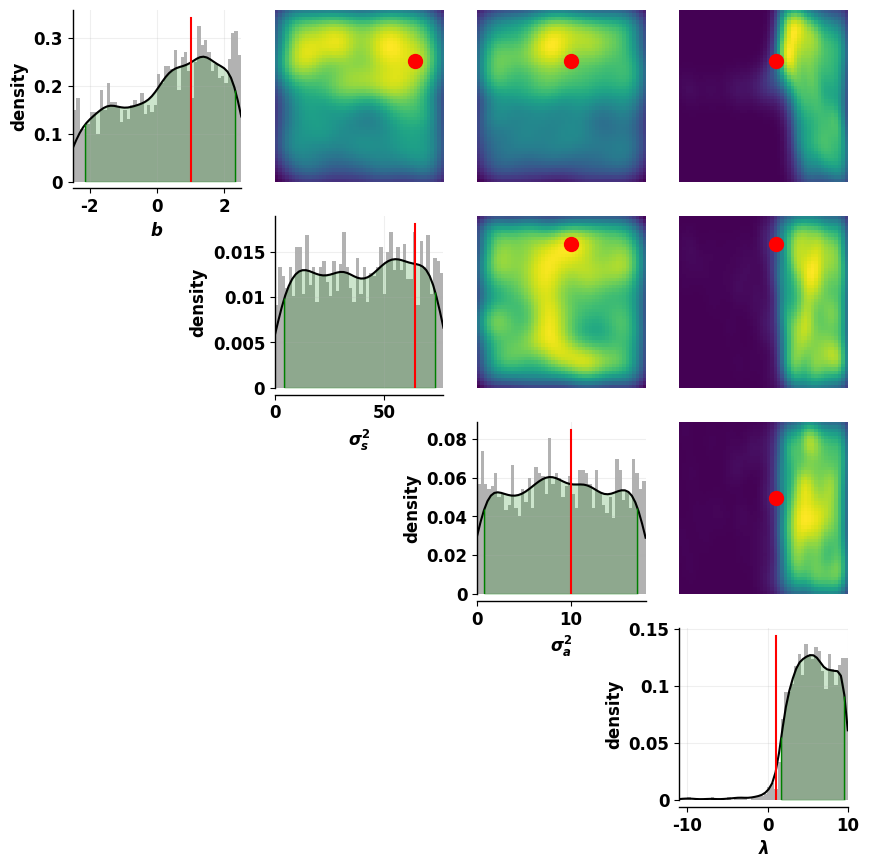

In [24]:
# load np array
params_idx = 12
samples_dir = f"{NSC_DIR}/codes/notebook/figures/nle/{log_exp_id}_posterior_samples_chosen_dur_2k_T{params_idx}.npy"
samples = np.load(samples_dir)
true_theta = params[params_idx, :]
true_theta = convert_samples_range(true_theta, designed_limits, normed_limits)

fig, ax, samples = mapped_samples_pair_plot(
    samples,
    true_theta=true_theta,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

save_fig = fig_dir / 'nle' / f'{log_exp_id}-one-posterior.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

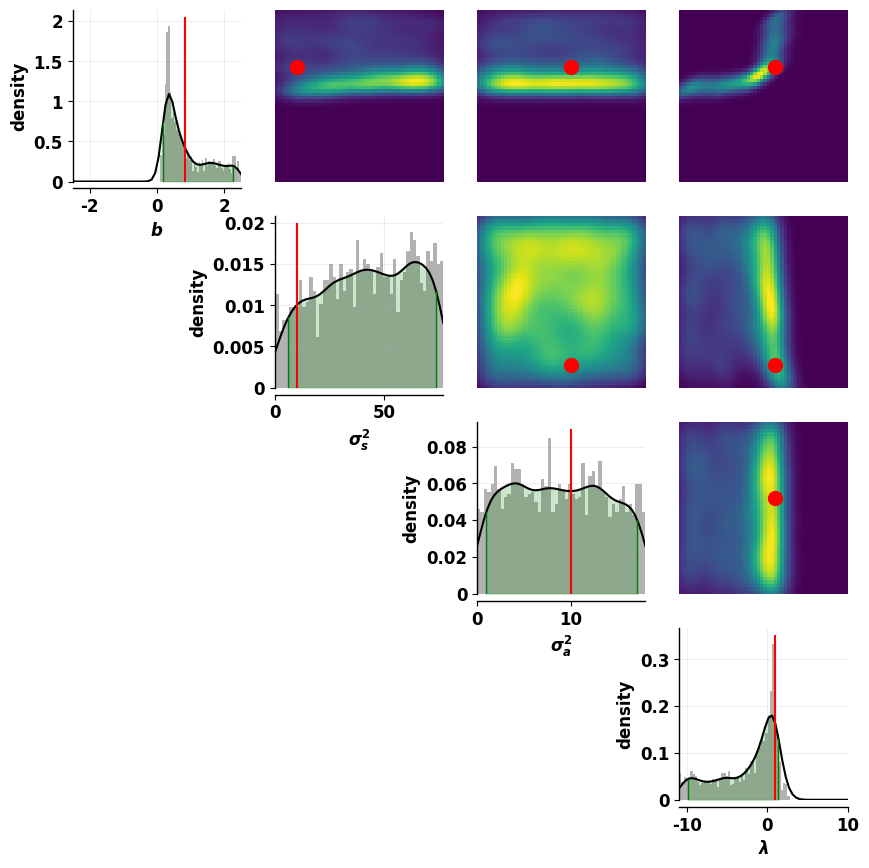

In [25]:
# load np array
params_idx = 4
samples_dir = f"{NSC_DIR}/codes/notebook/figures/nle/{log_exp_id}_posterior_samples_chosen_dur_2k_T{params_idx}.npy"
samples = np.load(samples_dir)
true_theta = params[params_idx, :]
true_theta = convert_samples_range(true_theta, designed_limits, normed_limits)

fig, ax, samples = mapped_samples_pair_plot(
    samples,
    true_theta=true_theta,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

save_fig = fig_dir / 'nle' / f'{log_exp_id}-one-posterior-2.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## check posterior CoV - change of variables

In [14]:
all_samples = np.zeros((4, step - 2, 2_000, 4))
all_thetas = np.zeros((4, step - 2, 4))

for T in range(nT):
# for T in [0]:
    # skip the first and last step cases
    if T % step == 0 or T % step == step - 1:
        continue
    # which theta is moving
    moving_theta_idx = T // step
    trial_idx = T % step - 1
    
    # == prepare the data for inference
    # = convert the theta to the normed range
    theta_test = torch.tensor(params[T, :]).clone().detach()
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    
    samples_dir = adapt_path(f"{NSC_DIR}/codes/notebook/figures/nle/{log_exp_id}_posterior_samples_chosen_dur_2k_T{T}.npy")
    samples = np.load(samples_dir)
    
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

/tmp/ipykernel_3448780/1786960352.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_test = torch.tensor(params[T, :]).clone().detach()


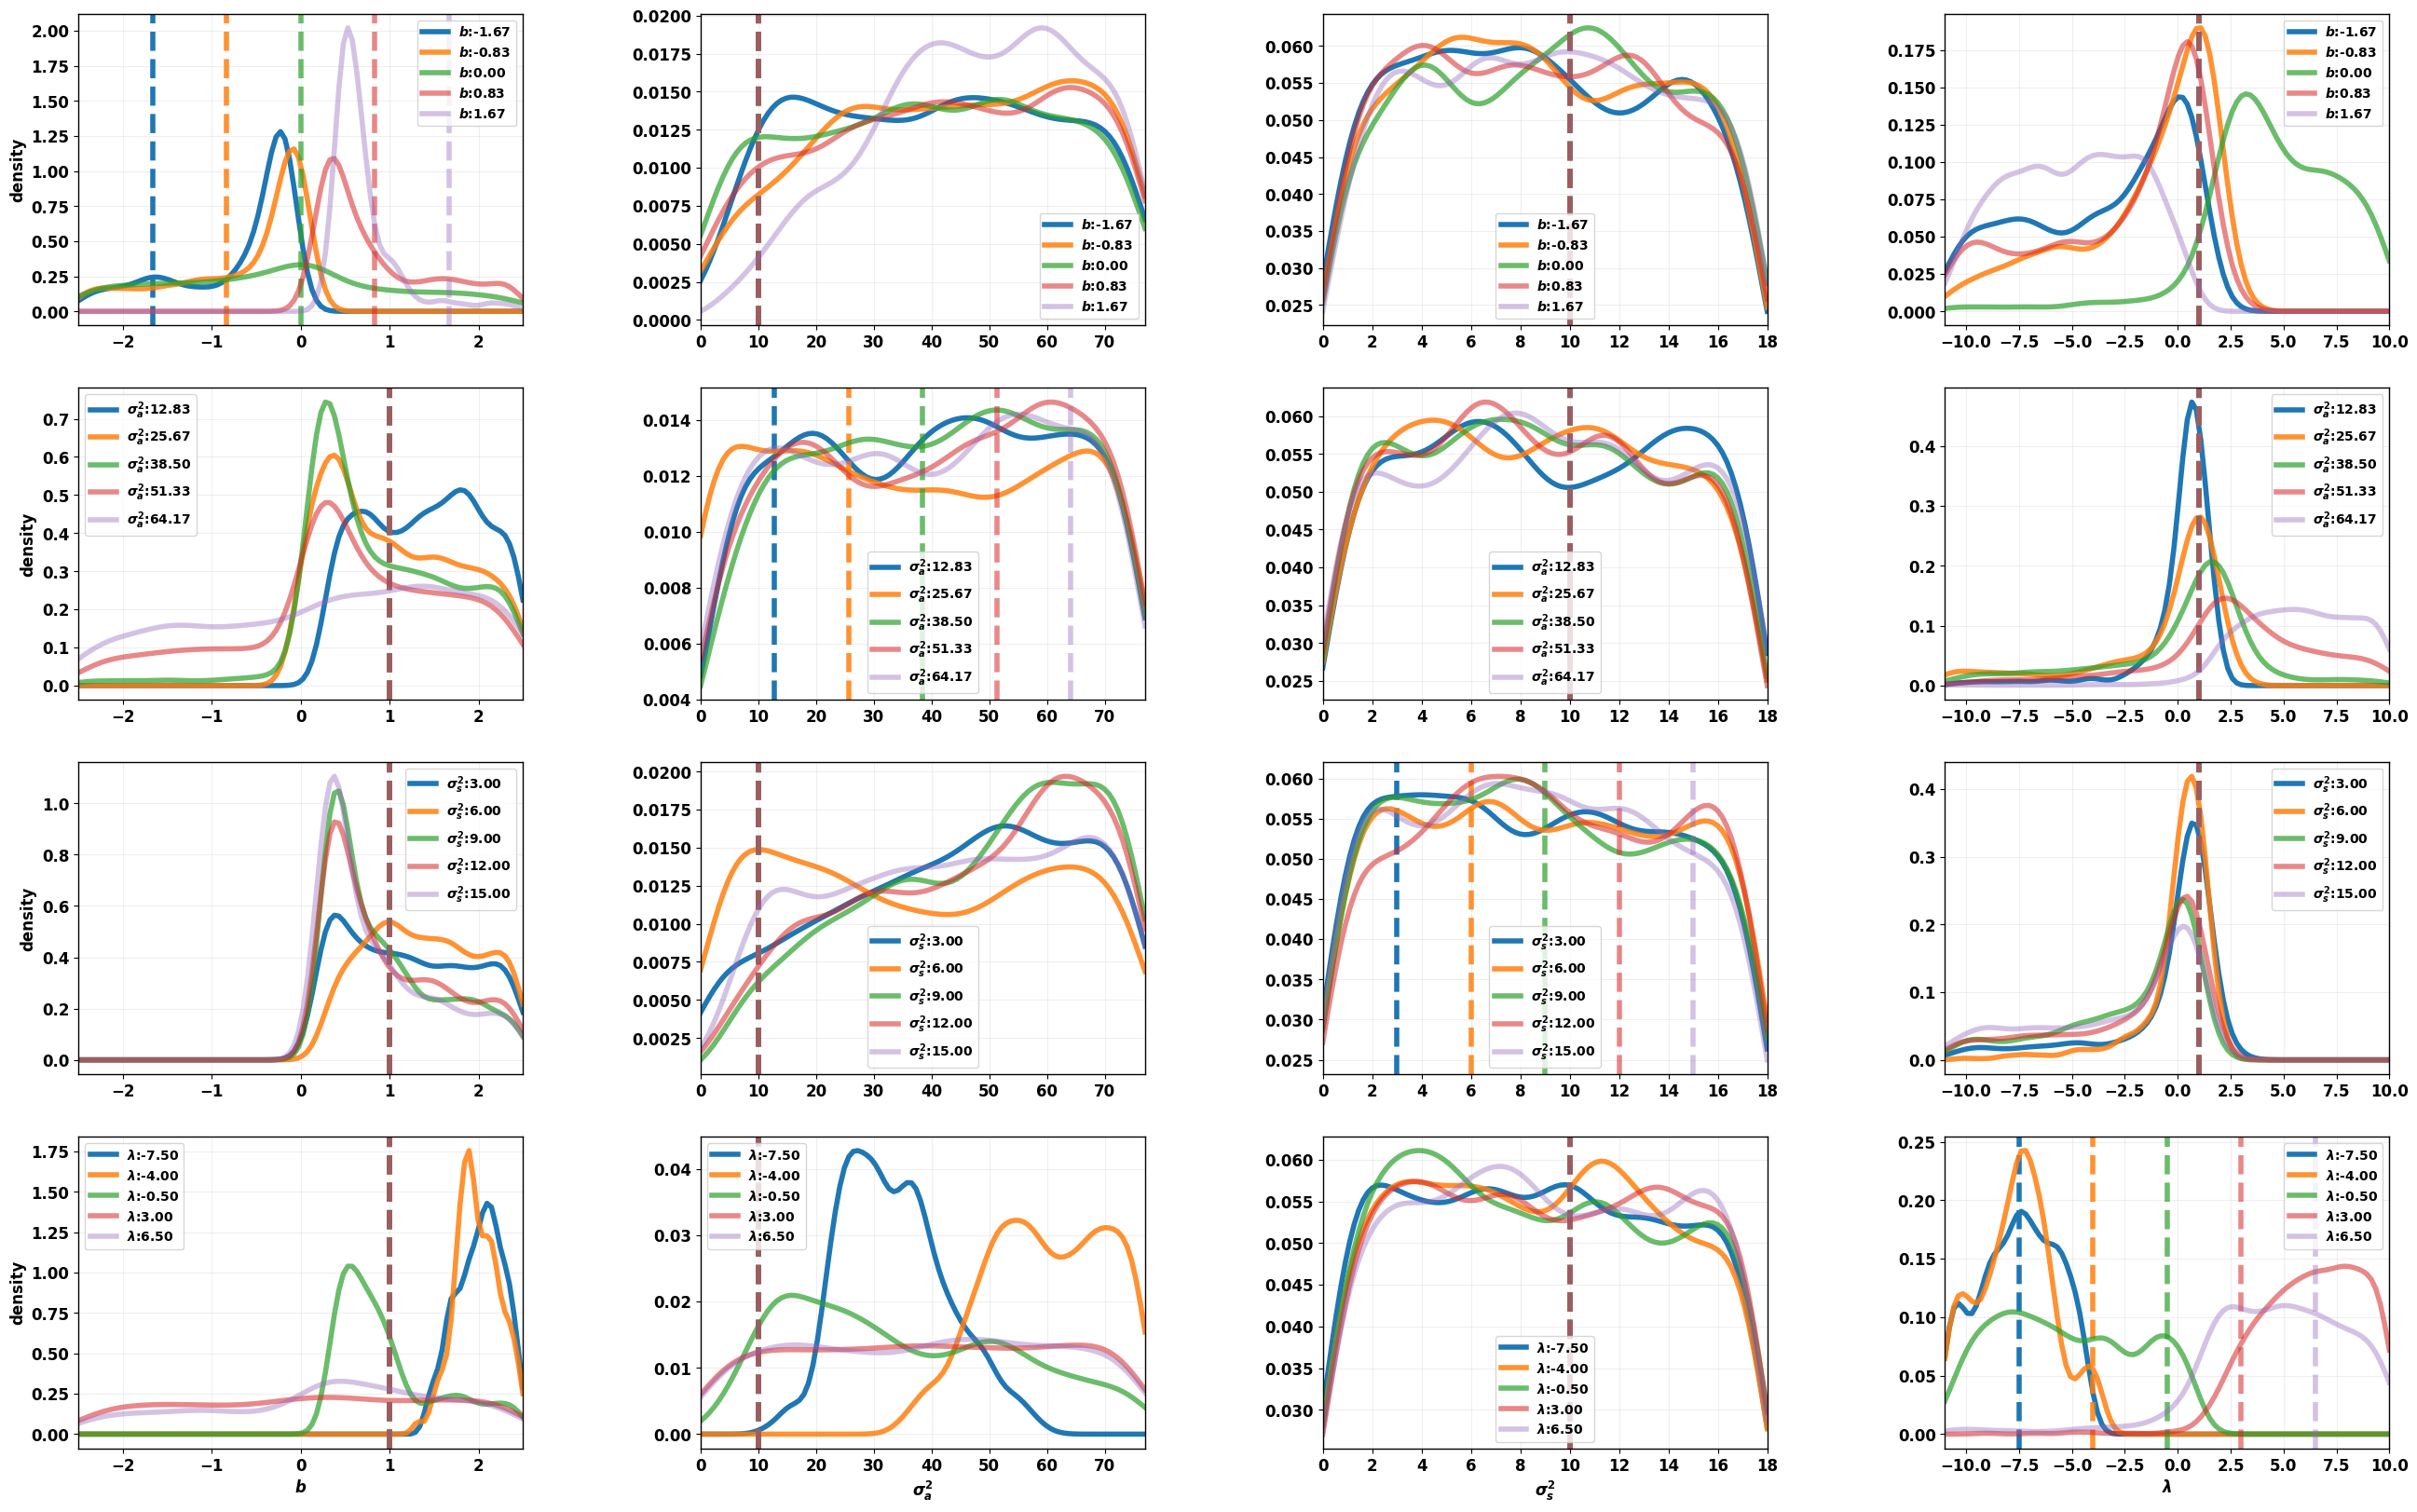

In [16]:
fig = CoV_plot(
    all_samples_dr,
    all_thetas_dr,
    num_params,
    designed_limits,
    prior_labels,
    colors,
)

save_fig = fig_dir / 'nle' / f'{log_exp_id}-CoV-chosen_dur-2k.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)